In [1]:
import seaborn as sn
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader, random_split
from torch import Tensor
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss, BCEWithLogitsLoss
from torch.optim import Adam
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pandas import DataFrame
import xlsxwriter
import time

seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import torch
torch.manual_seed(seed_value)

In [2]:
Training_Data = pd.ExcelFile("Training Data.xlsx") #Training Data already pre-scaled to the IBIS Data set
Label_Data = pd.ExcelFile("Labels.xlsx") #Labels
data = Training_Data.parse(Training_Data.sheet_names[1])
label_data = Label_Data.parse(Label_Data.sheet_names[1])
data_features = data.loc[:, data.columns]
data_features = data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'INDEX MEDU', 'MATCH DEMOS OLD', 'INDEX AGE'], axis=1)
data_features = data_features.dropna()
data_features = data_features.drop(['HYP'], axis=1)
labels = label_data.loc[:, label_data.columns]
labels = labels.drop(['ROI','MATCH BASC2', 'INDEX ATP', 'INDEX HYP', 'ATP'], axis=1)
labels = labels.dropna()
print(data_features.shape)
print(labels.shape)

(127, 300)
(127, 1)


In [3]:
interpolated_data = Training_Data.parse(Training_Data.sheet_names[6])
interpolated_data_features = interpolated_data.loc[:, interpolated_data.columns]
interpolated_data_features = interpolated_data_features.drop(['ROI','MATCH DEMOS','INDEX SEX','MATCH BASC2','INDEX GA', 'ATP', 'ATP Label', 'HYP Label', 'INDEX MEDU'], axis=1)
interpolated_data_features = interpolated_data_features.dropna()
interpolated_data_features = interpolated_data_features.drop(['HYP'], axis=1)

interpolated_label_data = Label_Data.parse(Label_Data.sheet_names[5])
interpolated_labels = interpolated_label_data.loc[:, interpolated_label_data.columns]
interpolated_labels = interpolated_labels.drop(['ROI','ATP'], axis=1)
interpolated_labels = interpolated_labels.dropna()

print(interpolated_data_features.shape)
print(interpolated_labels.shape)
print(type(interpolated_data_features))

(36, 300)
(36, 1)
<class 'pandas.core.frame.DataFrame'>


In [4]:
interpolated_data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,-0.251956,-0.086536,0.229623,0.060261,-0.231089,0.329678,0.181465,-0.134226,0.083773,0.029931,...,0.349822,0.510644,0.752820,0.497302,0.679110,0.416780,1,0.750000,18.0,2
1,-0.307963,-0.151483,0.250461,0.073782,-0.288914,0.307456,0.172618,-0.083658,0.171570,0.020927,...,0.281492,0.604401,0.809157,0.395572,0.529584,0.473531,0,0.833333,16.0,2
2,-0.298103,-0.148468,0.196355,0.038655,-0.277678,0.289809,0.138549,-0.164468,0.087299,-0.036124,...,0.219449,0.389463,0.389765,0.438533,0.719972,0.400837,0,0.833333,14.0,2
3,-0.275011,-0.083852,0.303753,0.079348,-0.243501,0.341732,0.235975,-0.033882,0.228387,0.115196,...,0.234086,0.561906,0.762178,0.548366,0.584529,0.550937,1,0.833333,12.0,2
4,-0.305531,-0.193406,0.199527,0.005128,-0.274699,0.268989,0.128775,-0.185563,0.000003,-0.141069,...,0.167164,0.318058,0.443165,0.382118,0.381881,0.216869,0,0.583333,14.0,2


In [5]:
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(data_features, labels)
print(skf)

training_indices_X = []
testing_indices_X = []
training_indices_Y = []
testing_indices_Y = []

for train_index, test_index in skf.split(data_features, labels):
  
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    Y_train, Y_test = labels.iloc[train_index], labels.iloc[test_index]
   
    sm = SMOTE(sampling_strategy = 'minority', random_state = seed_value, k_neighbors=2) 
    X_train_res, Y_train_res = sm.fit_sample(X_train, Y_train) #Only smote the training set.
    print(X_train_res.shape)
    training_indices_X.append(X_train_res)
    testing_indices_X.append(X_test)
    training_indices_Y.append(Y_train_res)
    testing_indices_Y.append(Y_test)


StratifiedKFold(n_splits=8, random_state=None, shuffle=False)
(198, 300)
(198, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)


In [6]:
training_indices_X[0].head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,SEX,Gestational Age,Maternal Education MEDU,Age at MRI 2
0,-0.135266,-0.059643,0.025812,0.055720,-0.258434,-0.093272,-0.311657,-0.375498,-0.142164,0.243936,...,0.039888,0.557574,0.261448,0.128994,0.354597,0.095201,1.0,0.833333,18.0,0.984932
1,-0.017157,0.158646,0.110138,0.045273,-0.111116,-0.296526,-0.045506,-0.206203,0.031987,0.073636,...,0.150108,0.404192,0.265967,0.190446,0.755571,0.433258,1.0,0.666667,17.0,1.019178
2,-0.153435,0.039954,0.024554,-0.099019,-0.072652,-0.226855,-0.320698,-0.293671,0.048250,0.739080,...,0.252215,0.129107,0.457043,0.363545,0.460403,0.459713,0.0,0.750000,17.0,1.001370
3,-0.173784,-0.086895,-0.044482,-0.140339,-0.132705,-0.341187,-0.244494,-0.364035,-0.062480,-0.095222,...,0.109657,0.128430,0.526648,0.083436,0.535189,0.444251,0.0,0.500000,14.0,1.008219
4,-0.384659,0.110031,0.069220,-0.116755,-0.405043,-0.095715,0.008814,-0.253376,-0.013787,0.106184,...,0.144029,0.241537,0.264994,0.284063,0.312178,0.391243,0.0,0.666667,19.0,1.015068


In [7]:
for x in training_indices_X:
    print(x.shape)
    
#Figure out how to loop this later. Wasn't working for the following code:
#for x in training_indices_X:
#    x = pd.concat([x,interpolated_data_features])

training_indices_X[0] = pd.concat([training_indices_X[0],interpolated_data_features])
training_indices_X[1] = pd.concat([training_indices_X[1],interpolated_data_features])
training_indices_X[2] = pd.concat([training_indices_X[2],interpolated_data_features])
training_indices_X[3] = pd.concat([training_indices_X[3],interpolated_data_features])
training_indices_X[4] = pd.concat([training_indices_X[4],interpolated_data_features])
training_indices_X[5] = pd.concat([training_indices_X[5],interpolated_data_features])
training_indices_X[6] = pd.concat([training_indices_X[6],interpolated_data_features])
training_indices_X[7] = pd.concat([training_indices_X[7],interpolated_data_features])

print('----------')
for x in training_indices_X:
    print(x.shape)
    
print('Label shapes')
    
for y in training_indices_Y:
    print(y.shape)

training_indices_Y[0] = pd.concat([training_indices_Y[0],interpolated_labels])
training_indices_Y[1] = pd.concat([training_indices_Y[1],interpolated_labels])
training_indices_Y[2] = pd.concat([training_indices_Y[2],interpolated_labels])
training_indices_Y[3] = pd.concat([training_indices_Y[3],interpolated_labels])
training_indices_Y[4] = pd.concat([training_indices_Y[4],interpolated_labels])
training_indices_Y[5] = pd.concat([training_indices_Y[5],interpolated_labels])
training_indices_Y[6] = pd.concat([training_indices_Y[6],interpolated_labels])
training_indices_Y[7] = pd.concat([training_indices_Y[7],interpolated_labels])

print('----------')
for y in training_indices_Y:
    print(y.shape)


(198, 300)
(198, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
(200, 300)
----------
(234, 300)
(234, 300)
(236, 300)
(236, 300)
(236, 300)
(236, 300)
(236, 300)
(236, 300)
Label shapes
(198, 1)
(198, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
(200, 1)
----------
(234, 1)
(234, 1)
(236, 1)
(236, 1)
(236, 1)
(236, 1)
(236, 1)
(236, 1)


In [8]:
#training_indices_X[0] #8 Folds so 0 -> 7 Data type is a DataFrame currently.
training_fold_X_0 = training_indices_X[0].to_numpy()
training_fold_X_1 = training_indices_X[1].to_numpy()
training_fold_X_2 = training_indices_X[2].to_numpy()
training_fold_X_3 = training_indices_X[3].to_numpy()
training_fold_X_4 = training_indices_X[4].to_numpy()
training_fold_X_5 = training_indices_X[5].to_numpy()
training_fold_X_6 = training_indices_X[6].to_numpy()
training_fold_X_7 = training_indices_X[7].to_numpy()

training_fold_Y_0 = training_indices_Y[0].to_numpy()
training_fold_Y_1 = training_indices_Y[1].to_numpy()
training_fold_Y_2 = training_indices_Y[2].to_numpy()
training_fold_Y_3 = training_indices_Y[3].to_numpy()
training_fold_Y_4 = training_indices_Y[4].to_numpy()
training_fold_Y_5 = training_indices_Y[5].to_numpy()
training_fold_Y_6 = training_indices_Y[6].to_numpy()
training_fold_Y_7 = training_indices_Y[7].to_numpy()

testing_fold_X_0 = testing_indices_X[0].to_numpy()
testing_fold_X_1 = testing_indices_X[1].to_numpy()
testing_fold_X_2 = testing_indices_X[2].to_numpy()
testing_fold_X_3 = testing_indices_X[3].to_numpy()
testing_fold_X_4 = testing_indices_X[4].to_numpy()
testing_fold_X_5 = testing_indices_X[5].to_numpy()
testing_fold_X_6 = testing_indices_X[6].to_numpy()
testing_fold_X_7 = testing_indices_X[7].to_numpy()

testing_fold_Y_0 = testing_indices_Y[0].to_numpy()
testing_fold_Y_1 = testing_indices_Y[1].to_numpy()
testing_fold_Y_2 = testing_indices_Y[2].to_numpy()
testing_fold_Y_3 = testing_indices_Y[3].to_numpy()
testing_fold_Y_4 = testing_indices_Y[4].to_numpy()
testing_fold_Y_5 = testing_indices_Y[5].to_numpy()
testing_fold_Y_6 = testing_indices_Y[6].to_numpy()
testing_fold_Y_7 = testing_indices_Y[7].to_numpy()

In [9]:
testing_fold_Y_1.shape

(16, 1)

In [10]:
#Some hyperparameters
#D_in is input dimension; H is hidden dimension; D_out is output dimension. 
#Best: 0.691927 using {'batch_size': 30, 'dropout': 0.3, 'epochs': 25, 'layer1_size': 130, 'layer2_size': 30}
D_in, H1, H2, D_out = 300, 130, 30, 1
EPOCHS = 25
BATCH_SIZE = 30
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.30
DROPOUT_RATE = 0.15

test_size = 19
test_size1 = 18

## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data): #used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)

#A dataloader is then used on this dataset class to read the data in batches.
train_data = trainData(torch.FloatTensor(training_fold_X_0), 
                       torch.FloatTensor(training_fold_Y_0))

train_data1 = trainData(torch.FloatTensor(training_fold_X_1), 
                       torch.FloatTensor(training_fold_Y_1))

train_data2 = trainData(torch.FloatTensor(training_fold_X_2), 
                       torch.FloatTensor(training_fold_Y_2))

train_data3 = trainData(torch.FloatTensor(training_fold_X_3), 
                       torch.FloatTensor(training_fold_Y_3))

train_data4 = trainData(torch.FloatTensor(training_fold_X_4), 
                       torch.FloatTensor(training_fold_Y_4))

train_data5 = trainData(torch.FloatTensor(training_fold_X_5), 
                       torch.FloatTensor(training_fold_Y_5))

train_data6 = trainData(torch.FloatTensor(training_fold_X_6), 
                       torch.FloatTensor(training_fold_Y_6))

train_data7 = trainData(torch.FloatTensor(training_fold_X_7), 
                       torch.FloatTensor(training_fold_Y_7))
## test data    
class testData(Dataset):
    
    def __init__(self, X_data): ##used to perform initializing operations such as reading data and preprocessing.
        self.X_data = X_data
        
    def __getitem__(self, index): #returns data (input and output) in batches.
        return self.X_data[index]
        
    def __len__ (self): #returns the size of the input data.
        return len(self.X_data)
    
#A dataloader is then used on this dataset class to read the data in batches.
test_data = testData(torch.FloatTensor(testing_fold_X_0))
test_data1 = testData(torch.FloatTensor(testing_fold_X_1))
test_data2 = testData(torch.FloatTensor(testing_fold_X_2))
test_data3 = testData(torch.FloatTensor(testing_fold_X_3))
test_data4 = testData(torch.FloatTensor(testing_fold_X_4))
test_data5 = testData(torch.FloatTensor(testing_fold_X_5))
test_data6 = testData(torch.FloatTensor(testing_fold_X_6))
test_data7 = testData(torch.FloatTensor(testing_fold_X_7))

#Initialize DataLoaders
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader1 = DataLoader(dataset=train_data1, batch_size=BATCH_SIZE, shuffle=True)
test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader2 = DataLoader(dataset=train_data2, batch_size=BATCH_SIZE, shuffle=True)
test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader3 = DataLoader(dataset=train_data3, batch_size=BATCH_SIZE, shuffle=True)
test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader4 = DataLoader(dataset=train_data4, batch_size=BATCH_SIZE, shuffle=True)
test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader5 = DataLoader(dataset=train_data5, batch_size=BATCH_SIZE, shuffle=True)
test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader6 = DataLoader(dataset=train_data6, batch_size=BATCH_SIZE, shuffle=True)
test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

train_loader7 = DataLoader(dataset=train_data7, batch_size=BATCH_SIZE, shuffle=True)
test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1) #Batch size of the validation set. Need 1 at a time for how it was setup in the tutorial.

In [11]:
print(testing_fold_X_0.shape)
print(testing_fold_X_1.shape)
print(testing_fold_X_2.shape)
print(testing_fold_X_3.shape)
print(testing_fold_X_4.shape)
print(testing_fold_X_5.shape)
print(testing_fold_X_6.shape)
print(testing_fold_X_7.shape)

(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(16, 300)
(15, 300)


In [12]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        # Number of input features is 298.
        self.layer_1 = nn.Linear(D_in, H1) #298 -> 100
        self.layer_2 = nn.Linear(H1, H2) #100 -> 15
        self.layer_out = nn.Linear(H2, D_out) #15 -> 1
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=DROPOUT_RATE)
        #self.batchnorm1 = nn.BatchNorm1d(100)
        #self.batchnorm2 = nn.BatchNorm1d(15)
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs)) #ReLU on the 298?
        #x = self.batchnorm1(x) #Normalize the 100
        x = self.dropout(x) #Dropout 15%
        x = self.relu(self.layer_2(x)) #ReLU on the 100?
        #x = self.batchnorm2(x) #Normalize the 15
        x = self.layer_out(x) #1
        
        return x
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#Should use the CPU since I don't have a GPU.

cpu


In [13]:
#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model = binaryClassification()
model.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model.train()
print(model)
weights = torch.FloatTensor([5]) #Class weights?
criterion = nn.BCEWithLogitsLoss(pos_weight=weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model1 = binaryClassification()
model1.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model1.train()
#print(model)
weights1 = torch.FloatTensor([5]) #Class weights?
criterion1 = nn.BCEWithLogitsLoss(pos_weight=weights1)
optimizer1 = optim.Adam(model1.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model2 = binaryClassification()
model2.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model2.train()
#print(model)
weights2 = torch.FloatTensor([5]) #Class weights?
criterion2 = nn.BCEWithLogitsLoss(pos_weight=weights2)
optimizer2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model3 = binaryClassification()
model3.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model3.train()
#print(model)
weights3 = torch.FloatTensor([5]) #Class weights?
criterion3 = nn.BCEWithLogitsLoss(pos_weight=weights3)
optimizer3 = optim.Adam(model3.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model4 = binaryClassification()
model4.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model4.train()
#print(model)
weights4 = torch.FloatTensor([5]) #Class weights?
criterion4 = nn.BCEWithLogitsLoss(pos_weight=weights4)
optimizer4 = optim.Adam(model4.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model5 = binaryClassification()
model5.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model5.train()
#print(model)
weights5 = torch.FloatTensor([5]) #Class weights?
criterion5 = nn.BCEWithLogitsLoss(pos_weight=weights5)
optimizer5 = optim.Adam(model5.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model6 = binaryClassification()
model6.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model6.train()
#print(model)
weights6 = torch.FloatTensor([5]) #Class weights?
criterion6 = nn.BCEWithLogitsLoss(pos_weight=weights6)
optimizer6 = optim.Adam(model6.parameters(), lr=LEARNING_RATE)

#Model initialization and information on layers. The model's actual architecture can be viewed in the forward function above.
model7 = binaryClassification()
model7.load_state_dict(torch.load('./model_dict_hyp_2yr.pth'))
model7.train()
#print(model)
weights7 = torch.FloatTensor([5]) #Class weights?
criterion7 = nn.BCEWithLogitsLoss(pos_weight=weights7)
optimizer7 = optim.Adam(model7.parameters(), lr=LEARNING_RATE)

binaryClassification(
  (layer_1): Linear(in_features=300, out_features=130, bias=True)
  (layer_2): Linear(in_features=130, out_features=30, bias=True)
  (layer_out): Linear(in_features=30, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.15, inplace=False)
)


In [14]:
#Function to define accuracy. Should look to see if there is a prebuilt that I can use from sci-kit learn or something.
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [15]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc = []
train_acc = []
train_loss = []
val_loss = []

model.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc.append(epoch_acc/len(train_loader))
    train_loss.append(epoch_loss/len(train_loader))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')
    #Validation metrics here
    model.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_0))
            val_loss.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_0), y_pred_list)
    ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc.append(accuracy*100)
    model.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.81324 | Acc: 47.750
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.88974 | Acc: 49.500
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.52024 | Acc: 45.875
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.41862 | Acc: 47.000
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35053 | Acc: 50.125
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.29383 | Acc: 51.750


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.30060 | Acc: 52.375
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 008: | Loss: 1.22447 | Acc: 55.375
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 009: | Loss: 1.22133 | Acc: 59.250
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 010: | Loss: 1.11669 | Acc: 59.625
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 011: | Loss: 1.01482 | Acc: 62.375
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 012: | Loss: 1.00029 | Acc: 60.750
Validation Accuracy |  12.5  PPV |  [1.         0.06666667]  Recall |  [0.06666667 1.        ]
Training Epoch 013: | Loss: 0.89708 | Acc: 65.625
Validatio

In [16]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc1 = []
train_acc1 = []
train_loss1 = []
val_loss1 = []

model1.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader1:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer1.zero_grad()
        
        y_pred = model1(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer1.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc1.append(epoch_acc/len(train_loader1))
    train_loss1.append(epoch_loss/len(train_loader1))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader1):.5f} | Acc: {epoch_acc/len(train_loader1):.3f}')
    #Validation metrics here
    model1.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader1 = DataLoader(dataset=test_data1, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader1:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_1))
            val_loss1.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader = DataLoader(dataset=test_data1, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader:
            X_batch = X_batch.to(device)
            y_test_pred = model1(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_1), y_pred_list)
    ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc1.append(accuracy*100)
    model1.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.03757 | Acc: 48.500
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.93169 | Acc: 43.125
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.57098 | Acc: 48.375
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.46019 | Acc: 47.625
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35205 | Acc: 49.750
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.23681 | Acc: 56.750


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.24750 | Acc: 57.875
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.17112 | Acc: 56.375
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.12873 | Acc: 59.000
Validation Accuracy |  6.25  PPV |  [0.     0.0625]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.08518 | Acc: 61.375
Validation Accuracy |  0.0  PPV |  [0. 0.]  Recall |  [0. 0.]
Training Epoch 011: | Loss: 1.02931 | Acc: 63.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.25  PPV |  [0.5 0. ]  Recall |  [0.06666667 0.        ]
Training Epoch 012: | Loss: 1.02377 | Acc: 67.000
Validation Accuracy |  6.25  PPV |  [0.5 0. ]  Recall |  [0.06666667 0.        ]
Training Epoch 013: | Loss: 0.90416 | Acc: 64.500
Validation Accuracy |  25.0  PPV |  [0.8 0. ]  Recall |  [0.26666667 0.        ]
Training Epoch 014: | Loss: 0.83160 | Acc: 71.375
Validation Accuracy |  25.0  PPV |  [0.8 0. ]  Recall |  [0.26666667 0.        ]
Training Epoch 015: | Loss: 0.80134 | Acc: 77.625
Validation Accuracy |  12.5  PPV |  [0.66666667 0.        ]  Recall |  [0.13333333 0.        ]
Training Epoch 016: | Loss: 0.71083 | Acc: 74.250
Validation Accuracy |  43.75  PPV |  [0.875 0.   ]  Recall |  [0.46666667 0.        ]
Training Epoch 017: | Loss: 0.67603 | Acc: 81.125
Validation Accuracy |  25.0  PPV |  [0.8 0. ]  Recall |  [0.26666667 0.        ]
Training Epoch 018: | Loss: 0.62139 | Acc: 82.875
Validation Accuracy |  62.5  PPV |  [0.90909091 0.        ]  Rec

In [17]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc2 = []
train_acc2 = []
train_loss2 = []
val_loss2 = []

model2.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader2:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer2.zero_grad()
        
        y_pred = model2(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer2.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc2.append(epoch_acc/len(train_loader2))
    train_loss2.append(epoch_loss/len(train_loader2))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader2):.5f} | Acc: {epoch_acc/len(train_loader2):.3f}')
    #Validation metrics here
    model2.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_2))
            val_loss2.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader2 = DataLoader(dataset=test_data2, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader2:
            X_batch = X_batch.to(device)
            y_test_pred = model2(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_2), y_pred_list)
    ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc2.append(accuracy*100)
    model2.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.19433 | Acc: 51.125
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 002: | Loss: 1.61221 | Acc: 55.250
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 003: | Loss: 1.45002 | Acc: 55.875
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 004: | Loss: 1.28814 | Acc: 56.875
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 005: | Loss: 1.20232 | Acc: 58.500
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 006: | Loss: 1.14265 | Acc: 62.875
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 007: | Loss: 1.15887 | Acc: 63.250
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.1428

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc3 = []
train_acc3 = []
train_loss3 = []
val_loss3 = []

model3.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader3:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer3.zero_grad()
        
        y_pred = model3(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer3.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc3.append(epoch_acc/len(train_loader3))
    train_loss3.append(epoch_loss/len(train_loader3))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader3):.5f} | Acc: {epoch_acc/len(train_loader3):.3f}')
    #Validation metrics here
    model3.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=test_size)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_3))
            val_loss3.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader3 = DataLoader(dataset=test_data3, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader3:
            X_batch = X_batch.to(device)
            y_test_pred = model3(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_3), y_pred_list)
    ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc3.append(accuracy*100)
    model3.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.52244 | Acc: 52.500
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 002: | Loss: 1.73742 | Acc: 54.625
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.50590 | Acc: 52.250
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 004: | Loss: 1.34606 | Acc: 50.875
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.24623 | Acc: 53.500
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 006: | Loss: 1.25834 | Acc: 57.375
Validation Accuracy |  18.75  PPV |  [0.66666667 0.07692308]  Recall |  [0.14285714 0.5       ]
Training Epoch 007: | Loss: 1.20818 | Acc: 55.125
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.

In [19]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc4 = []
train_acc4 = []
train_loss4 = []
val_loss4 = []

model4.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader4:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer4.zero_grad()
        
        y_pred = model4(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer4.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc4.append(epoch_acc/len(train_loader4))
    train_loss4.append(epoch_loss/len(train_loader4))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader4):.5f} | Acc: {epoch_acc/len(train_loader4):.3f}')
    #Validation metrics here
    model4.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_4))
            val_loss4.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader4 = DataLoader(dataset=test_data4, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader4:
            X_batch = X_batch.to(device)
            y_test_pred = model4(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_4), y_pred_list)
    ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc4.append(accuracy*100)
    model4.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.88409 | Acc: 47.375
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 002: | Loss: 2.22052 | Acc: 50.625
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.64001 | Acc: 45.875
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.45873 | Acc: 45.500
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 005: | Loss: 1.39658 | Acc: 55.125
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 006: | Loss: 1.29887 | Acc: 50.125
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 007: | Loss: 1.26286 | Acc: 55.250


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 008: | Loss: 1.19167 | Acc: 58.375
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 009: | Loss: 1.14742 | Acc: 59.375
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 010: | Loss: 1.10927 | Acc: 61.750
Validation Accuracy |  12.5  PPV |  [0.5        0.07142857]  Recall |  [0.07142857 0.5       ]
Training Epoch 011: | Loss: 1.04073 | Acc: 64.625
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 012: | Loss: 0.94509 | Acc: 72.500
Validation Accuracy |  25.0  PPV |  [0.75       0.08333333]  Recall |  [0.21428571 0.5       ]
Training Epoch 013: | Loss: 0.87585 | Acc: 69.500
Validation Accuracy |  25.0  PPV |  [0.66666667 0.        ]  Recall |  [0.28571429 0.        ]
Training Epoch 014: | Loss: 0.79

In [20]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc5 = []
train_acc5 = []
train_loss5 = []
val_loss5 = []

model5.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader5:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer5.zero_grad()
        
        y_pred = model5(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer5.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc5.append(epoch_acc/len(train_loader5))
    train_loss5.append(epoch_loss/len(train_loader5))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader5):.5f} | Acc: {epoch_acc/len(train_loader5):.3f}')
    #Validation metrics here
    model5.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_5))
            val_loss5.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader5 = DataLoader(dataset=test_data5, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader5:
            X_batch = X_batch.to(device)
            y_test_pred = model5(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_5), y_pred_list)
    ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc5.append(accuracy*100)
    model5.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.47009 | Acc: 52.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 1.76325 | Acc: 51.375
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.51346 | Acc: 47.125
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.39405 | Acc: 47.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.35307 | Acc: 52.750
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.26580 | Acc: 53.875

C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s


Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.28281 | Acc: 55.375
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.19723 | Acc: 56.250
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.12246 | Acc: 62.000
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 010: | Loss: 1.06458 | Acc: 62.375


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.02846 | Acc: 63.375
Validation Accuracy |  37.5  PPV |  [1.         0.16666667]  Recall |  [0.28571429 1.        ]
Training Epoch 012: | Loss: 0.98015 | Acc: 65.250
Validation Accuracy |  37.5  PPV |  [1.         0.16666667]  Recall |  [0.28571429 1.        ]
Training Epoch 013: | Loss: 0.93979 | Acc: 72.000
Validation Accuracy |  31.25  PPV |  [1.         0.15384615]  Recall |  [0.21428571 1.        ]
Training Epoch 014: | Loss: 0.84429 | Acc: 70.125
Validation Accuracy |  68.75  PPV |  [1.         0.28571429]  Recall |  [0.64285714 1.        ]
Training Epoch 015: | Loss: 0.76568 | Acc: 79.000
Validation Accuracy |  50.0  PPV |  [1.  0.2]  Recall |  [0.42857143 1.        ]
Training Epoch 016: | Loss: 0.74254 | Acc: 76.875
Validation Accuracy |  62.5  PPV |  [1.   0.25]  Recall |  [0.57142857 1.        ]
Training Epoch 017: | Loss: 0.66084 | Acc: 81.750
Validation Accuracy |  68.75  PPV |

In [21]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc6 = []
train_acc6 = []
train_loss6 = []
val_loss6 = []

model6.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader6:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer6.zero_grad()
        
        y_pred = model6(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer6.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc6.append(epoch_acc/len(train_loader6))
    train_loss6.append(epoch_loss/len(train_loader6))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader6):.5f} | Acc: {epoch_acc/len(train_loader6):.3f}')
    #Validation metrics here
    model6.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_6))
            val_loss6.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader6 = DataLoader(dataset=test_data6, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader6:
            X_batch = X_batch.to(device)
            y_test_pred = model6(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_6), y_pred_list)
    ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc6.append(accuracy*100)
    model6.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 2.92848 | Acc: 50.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 2.15293 | Acc: 43.625
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 003: | Loss: 1.62774 | Acc: 52.750
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 004: | Loss: 1.46746 | Acc: 48.125
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.44979 | Acc: 44.500
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.39466 | Acc: 44.625
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.32636 | Acc: 50.875


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 008: | Loss: 1.30029 | Acc: 50.375
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.24634 | Acc: 53.250
Validation Accuracy |  12.5  PPV |  [0.    0.125]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.22324 | Acc: 57.500
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 011: | Loss: 1.16917 | Acc: 56.500
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 012: | Loss: 1.08746 | Acc: 56.750
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 013: | Loss: 1.05001 | Acc: 59.750
Validation Accuracy |  37.5  PPV |  [1.         0.16666667]  Recall |  [0.28571429 1.        ]
Training Epoch 014: | Loss: 1.00552 | Acc: 61.500
Validation Accuracy |  18.75  PPV |  [1.         0.13333333]  Recall |  [0.07142857 1.        ]
Training Epoch 015: | Loss: 0.940

In [22]:
#model.train() tells PyTorch that you’re in training mode.
#Similarly, we’ll call model.eval() when we test our model. We’ll see that below.
'''If you’re using layers such as Dropout or BatchNorm which behave differently during training and evaluation, 
you need to tell PyTorch to act accordingly. While the default mode in PyTorch is the train, 
so, you don’t explicitly have to write that. But it’s good practice.'''
val_acc7 = []
train_acc7 = []
train_loss7 = []
val_loss7 = []

model7.train() #Initial training mode
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader7:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer7.zero_grad()
        
        y_pred = model7(X_batch)
        
        loss = criterion(y_pred, y_batch)
        acc = binary_acc(y_pred, y_batch)
        
        loss.backward()
        optimizer7.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    train_acc7.append(epoch_acc/len(train_loader7))
    train_loss7.append(epoch_loss/len(train_loader7))
    print(f'Training Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader7):.5f} | Acc: {epoch_acc/len(train_loader7):.3f}')
    #Validation metrics here
    model7.eval()
    #print("Evaluation mode")
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=test_size1)
    with torch.no_grad():
        counter = 0
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            loss = criterion(y_test_pred,torch.FloatTensor(testing_fold_Y_7))
            val_loss7.append(loss)
            counter+=1
            
    y_pred_list = []
    test_loader7 = DataLoader(dataset=test_data7, batch_size=1)
    with torch.no_grad():
        for X_batch in test_loader7:
            X_batch = X_batch.to(device)
            y_test_pred = model7(X_batch)
            y_test_pred = torch.sigmoid(y_test_pred)
            y_pred_tag = torch.round(y_test_pred)
            y_pred_list.append(y_pred_tag.cpu().numpy())
            
    y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
    y_loss_df = pd.DataFrame(y_pred_list)
    accuracy = accuracy_score(torch.FloatTensor(testing_fold_Y_7), y_pred_list)
    ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
    recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
    print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
    val_acc7.append(accuracy*100)
    model7.train()
    #print("Return to training mode")
    
    #Need to get validation loss.

Training Epoch 001: | Loss: 3.19708 | Acc: 46.750
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 002: | Loss: 2.28382 | Acc: 43.500
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 003: | Loss: 1.61922 | Acc: 48.250
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 004: | Loss: 1.47903 | Acc: 48.500
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 005: | Loss: 1.40431 | Acc: 45.875
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 006: | Loss: 1.34579 | Acc: 46.125


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 007: | Loss: 1.35241 | Acc: 47.625
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 008: | Loss: 1.32470 | Acc: 53.000
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 009: | Loss: 1.22396 | Acc: 54.000


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 010: | Loss: 1.20102 | Acc: 54.250
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 011: | Loss: 1.20142 | Acc: 55.875
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 012: | Loss: 1.19273 | Acc: 57.250
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 013: | Loss: 1.13886 | Acc: 58.875
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 014: | Loss: 1.10448 | Acc: 59.000
Validation Accuracy |  6.666666666666667  PPV |  [0.         0.06666667]  Recall |  [0. 1.]
Training Epoch 015: | Loss: 1.03531 | Acc: 63.625


C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattbeze\Anaconda3\envs\pytorch\lib\s

Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 016: | Loss: 1.00107 | Acc: 59.750
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 017: | Loss: 0.91213 | Acc: 64.875
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 018: | Loss: 0.90323 | Acc: 68.500
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 019: | Loss: 0.83740 | Acc: 65.500
Validation Accuracy |  13.333333333333334  PPV |  [1.         0.07142857]  Recall |  [0.07142857 1.        ]
Training Epoch 020: | Loss: 0.77850 | Acc: 82.375
Validation Accuracy |  20.0  PPV |  [1.         0.07692308]  Recall |  [0.14285714 1.        ]
Training Epoch 021: | Loss: 0.73001 | Acc: 72.625
Validation Accuracy |  13.333333333333334  PPV |  [1.       

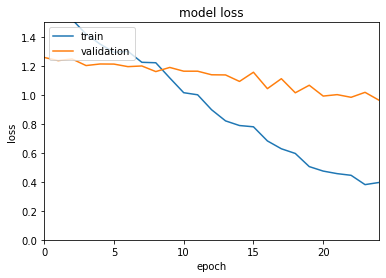

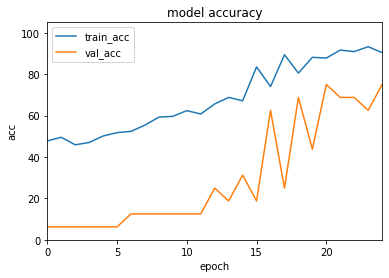

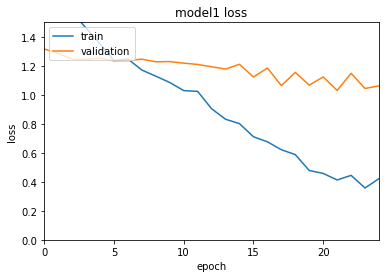

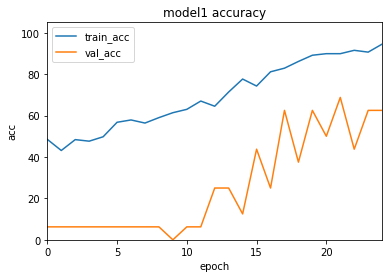

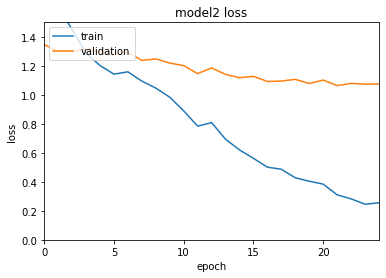

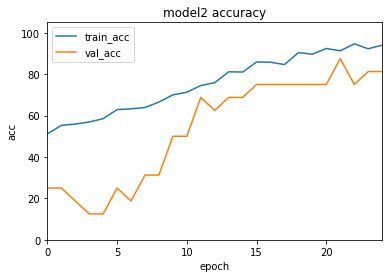

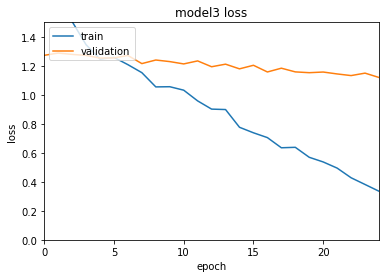

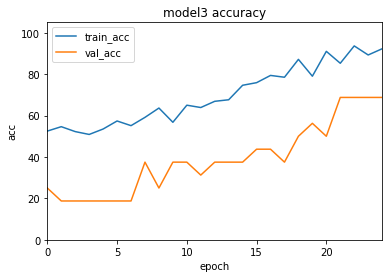

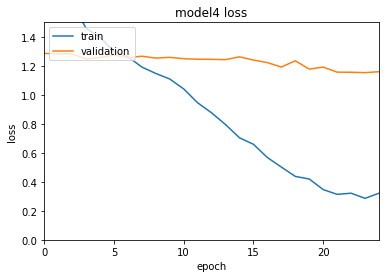

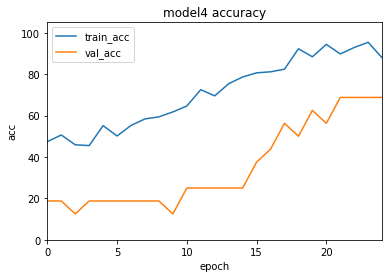

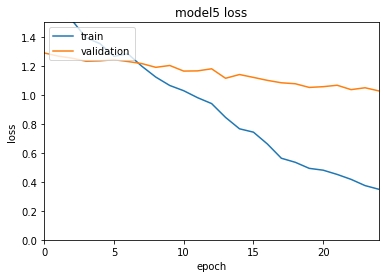

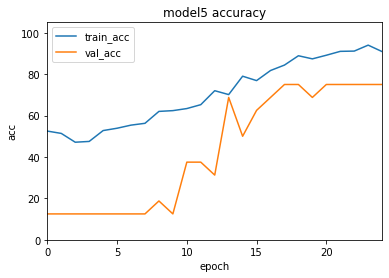

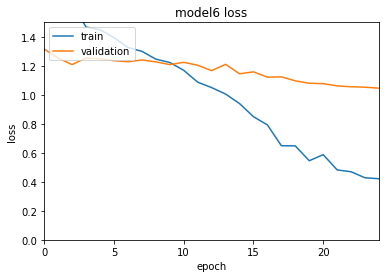

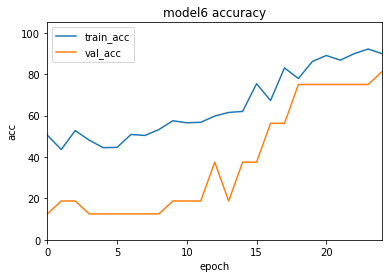

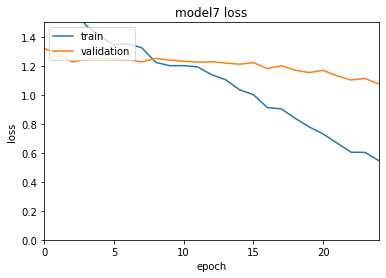

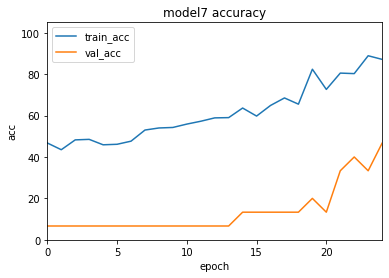

In [23]:
#Plotting loss
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss1)
plt.plot(val_loss1)
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc1)
plt.plot(val_acc1)
plt.title('model1 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss2)
plt.plot(val_loss2)
plt.title('model2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc2)
plt.plot(val_acc2)
plt.title('model2 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss3)
plt.plot(val_loss3)
plt.title('model3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc3)
plt.plot(val_acc3)
plt.title('model3 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss4)
plt.plot(val_loss4)
plt.title('model4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc4)
plt.plot(val_acc4)
plt.title('model4 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss5)
plt.plot(val_loss5)
plt.title('model5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc5)
plt.plot(val_acc5)
plt.title('model5 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss6)
plt.plot(val_loss6)
plt.title('model6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc6)
plt.plot(val_acc6)
plt.title('model6 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

#Plotting loss
plt.plot(train_loss7)
plt.plot(val_loss7)
plt.title('model7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 1.5])
plt.show()

#Plotting Accuracy
plt.plot(train_acc7)
plt.plot(val_acc7)
plt.title('model7 accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper left')
plt.axis([0, EPOCHS-1, 0.0, 105])
plt.show()

Validation Accuracy |  75.0  PPV |  [0.92307692 0.        ]  Recall |  [0.8 0. ]


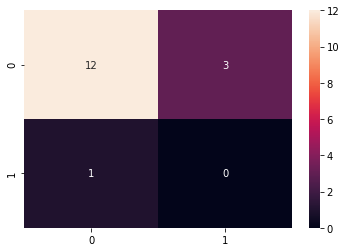

In [24]:
final_prediction = []
final_prediction_true = []

y_pred_list = []
test_loader = DataLoader(dataset=test_data, batch_size=1)
model.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_0, y_pred_list)
ppv = precision_score(testing_fold_Y_0, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_0, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_0, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_0:
    final_prediction_true.append(y)

Validation Accuracy |  62.5  PPV |  [0.90909091 0.        ]  Recall |  [0.66666667 0.        ]


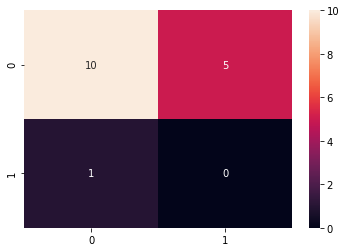

In [25]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data1, batch_size=1)
model1.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model1(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_1, y_pred_list)
ppv = precision_score(testing_fold_Y_1, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_1, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_1, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_1:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.86666667 0.        ]  Recall |  [0.92857143 0.        ]


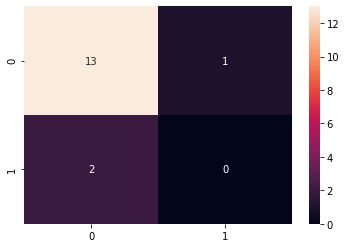

In [26]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data2, batch_size=1)
model2.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model2(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_2, y_pred_list)
ppv = precision_score(testing_fold_Y_2, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_2, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_2, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_2:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]


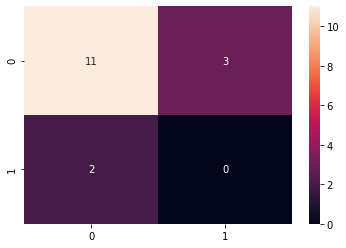

In [27]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data3, batch_size=1)
model3.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model3(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_3, y_pred_list)
ppv = precision_score(testing_fold_Y_3, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_3, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_3, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_3:
    final_prediction_true.append(y)

Validation Accuracy |  68.75  PPV |  [0.84615385 0.        ]  Recall |  [0.78571429 0.        ]


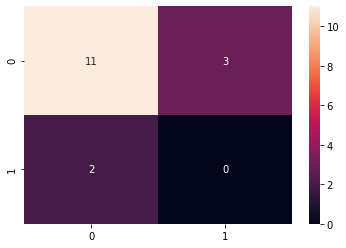

In [28]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data4, batch_size=1)
model4.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model4(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_4, y_pred_list)
ppv = precision_score(testing_fold_Y_4, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_4, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_4, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_4:
    final_prediction_true.append(y)

Validation Accuracy |  75.0  PPV |  [0.91666667 0.25      ]  Recall |  [0.78571429 0.5       ]


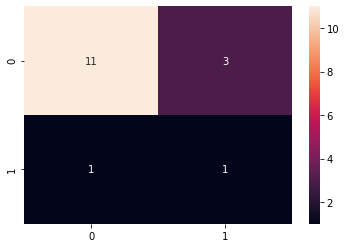

In [29]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data5, batch_size=1)
model5.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model5(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_5, y_pred_list)
ppv = precision_score(testing_fold_Y_5, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_5, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_5, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_5:
    final_prediction_true.append(y)

Validation Accuracy |  81.25  PPV |  [0.92307692 0.33333333]  Recall |  [0.85714286 0.5       ]


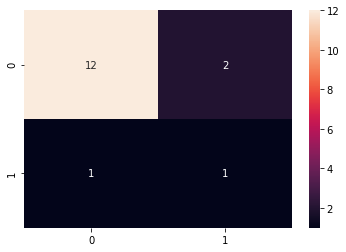

In [30]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data6, batch_size=1)
model6.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model6(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_6, y_pred_list)
ppv = precision_score(testing_fold_Y_6, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_6, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_6, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_6:
    final_prediction_true.append(y)

Validation Accuracy |  46.666666666666664  PPV |  [1.         0.11111111]  Recall |  [0.42857143 1.        ]


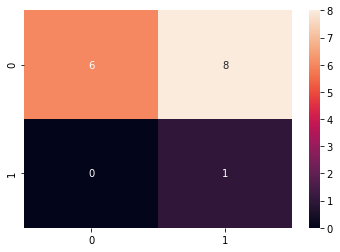

In [31]:
y_pred_list = []
test_loader = DataLoader(dataset=test_data7, batch_size=1)
model7.eval() #Model evaluation
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model7(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        final_prediction.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
accuracy = accuracy_score(testing_fold_Y_7, y_pred_list)
ppv = precision_score(testing_fold_Y_7, y_pred_list, average=None)
recall = recall_score(testing_fold_Y_7, y_pred_list, average=None)
print("Validation Accuracy | ",accuracy*100," PPV | ",ppv," Recall | ",recall)
cf_matrix = confusion_matrix(testing_fold_Y_7, y_pred_list)
sn.heatmap(cf_matrix, annot=True)

for y in testing_fold_Y_7:
    final_prediction_true.append(y)

In [32]:
prediction_labels = []
true_labels = []

for x in range(0,len(final_prediction_true)):
    true_labels.append(final_prediction_true[x][0])
    prediction_labels.append(final_prediction[x][0][0])

prediction_labels

[0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0]

[[86 28]
 [10  3]]
Positive Predictive Value tp/(tp+fp):  0.0967741935483871
Accuracy Value (tp+tn)/(tp+fp+fn+tn):  0.7007874015748031
Recall Value tp/(tp+fn):  0.23076923076923078


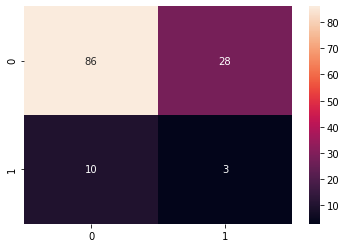

In [33]:
cf_matrix = confusion_matrix(true_labels, prediction_labels)
print(cf_matrix)
sn.heatmap(cf_matrix, annot=True)


accuracy = accuracy_score(true_labels, prediction_labels)
recall = recall_score(true_labels, prediction_labels, average=None)
prec_score = precision_score(true_labels, prediction_labels, average=None)
print('Positive Predictive Value tp/(tp+fp): ',prec_score[1]) 
print('Accuracy Value (tp+tn)/(tp+fp+fn+tn): ',accuracy) 
print('Recall Value tp/(tp+fn): ',recall[1]) 